In [2]:
import os

import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# Save
def show_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis('off')

In [20]:
# Save
def show_grid(array, labels, class_names=None, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(array[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            lbl = int(labels[index])
            label = class_names[lbl] if class_names else lbl
            plt.title(label, fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [93]:
cifar = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar.load_data()

In [6]:
X_train_full.shape, X_train_full.dtype

((50000, 32, 32, 3), dtype('uint8'))

In [94]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

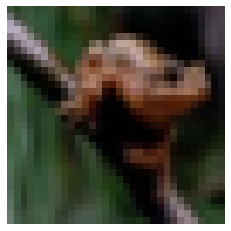

In [95]:
show_image(X_train[0])

In [10]:
y_train

array([[1],
       [6],
       [6],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [91]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

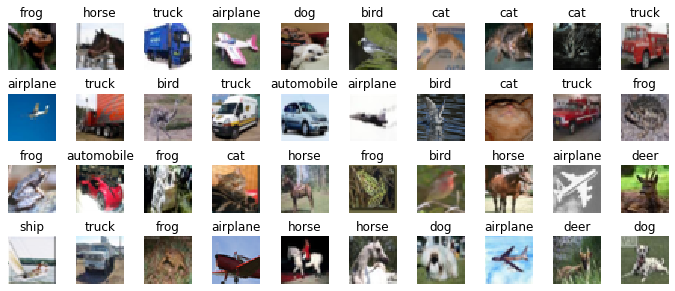

In [96]:
show_grid(X_train, y_train, class_names)

In [74]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

313/313 [==============================] - 3s 9ms/step - loss: 41142280257536.0000 - accuracy: 0.1137


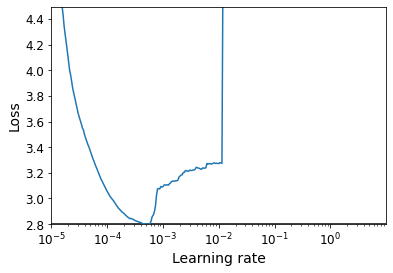

In [75]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

### Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function 

In [97]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for layer in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal", activation="elu"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

In [98]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [99]:
n_epoch=100
bs=128

In [100]:
lr0 = 5e-5
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [103]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=n_epoch, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb, model_checkpoint_cb], batch_size=bs)

Epoch 1/100
352/352 [==============================] - 3s 9ms/step - loss: 1.6818 - accuracy: 0.3894 - val_loss: 1.7050 - val_accuracy: 0.3762
Epoch 2/100
352/352 [==============================] - 3s 9ms/step - loss: 1.6593 - accuracy: 0.3972 - val_loss: 1.6981 - val_accuracy: 0.3790
Epoch 3/100
352/352 [==============================] - 3s 9ms/step - loss: 1.6392 - accuracy: 0.4063 - val_loss: 1.6855 - val_accuracy: 0.3876
Epoch 4/100
352/352 [==============================] - 3s 9ms/step - loss: 1.6215 - accuracy: 0.4114 - val_loss: 1.6797 - val_accuracy: 0.3860
Epoch 5/100
352/352 [==============================] - 3s 8ms/step - loss: 1.5999 - accuracy: 0.4189 - val_loss: 1.6526 - val_accuracy: 0.3902
Epoch 6/100
352/352 [==============================] - 3s 8ms/step - loss: 1.5825 - accuracy: 0.4270 - val_loss: 1.6833 - val_accuracy: 0.4004
Epoch 7/100
352/352 [==============================] - 3s 9ms/step - loss: 1.5653 - accuracy: 0.4352 - val_loss: 1.6323 - val_accuracy: 0.4144

In [104]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5373 - accuracy: 0.4648


[1.5373338460922241, 0.46480000019073486]

### c.
Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?